In [1]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
from config import configuration
config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [2]:
import seaborn as sns

In [6]:
import sqlutilpy
def load_mira_dset():
    mira_table = pd.read_csv('../mira_sample.csv')
    
    mira_ids = ','.join(np.str(s) for s in mira_table['virac_id'].values)
    
    from interface_utils.add_stats import main_string, var_string, pct_diff, phot_string, error_ratios
    
    dsets = pd.DataFrame(
            sqlutilpy.get("""with t as (
                            select {0} from 
                            leigh_smith.virac2 as t where t.sourceid in ({3}))
                            select {0}, {2}, {1} from t
                            inner join leigh_smith.virac2_photstats as y on y.sourceid=t.sourceid
                            inner join leigh_smith.virac2_var_indices as s on s.sourceid=t.sourceid;
                            """.format(main_string, var_string, phot_string, mira_ids),
                        **config.wsdb_kwargs))

    ## Now filter
    dsets = dsets[(dsets['ks_n_detections']>np.int64(config['n_detection_threshold']))&
                  (dsets['ks_b_ivw_mean_mag']>np.float64(config['lower_k']))&
                  (dsets['ks_b_ivw_mean_mag']<np.float64(config['upper_k']))].reset_index(drop=True)
    
    dsets = pct_diff(dsets)
    dsets = error_ratios(dsets)
    dsets['var_class']='MIRA'
    
    return dsets

In [7]:
mm = load_mira_dset()

In [8]:
len(mm)

705

In [67]:
with open('/local/scratch_2/jls/virac_classifier/binary/edr3_SJ/binary_training_set_33.pkl', 'rb') as f:
    binary = pickle.load(f)

In [68]:
ll=pd.merge(binary.training_set, mm, left_on='sourceid', right_on='sourceid', how='right')
print(np.count_nonzero(ll['var_class_x']!=ll['var_class_x']))

537


In [7]:
# if ~hasattr(binary, 'periodic_features'):
#     binary.periodic_features=[]
# if ~hasattr(binary, 'no_upper_features'):
#     binary.no_upper_features=[]
# mm_rslt=binary.predict(mm)


# with open('/local/scratch_2/jls/virac_classifier/binary/edr3/binary_training_set_24.pkl', 'rb') as f:
#     binary = pickle.load(f)
#     if ~hasattr(binary, 'periodic_features'):
#         binary.periodic_features=[]
#     if ~hasattr(binary, 'no_upper_features'):
#         binary.no_upper_features=[]
#     mm_rslt=binary.predict(mm)
#     mm2 = mm.copy()
#     mm2['class']=mm_rslt['class']
#     mm2['detailed_var_class']='MIRA'
#     mm2['var_class']='VAR'
    
#     binary.training_set = pd.concat([binary.training_set,mm2],sort=False)
    

NameError: name 'binary' is not defined

In [22]:
gg = glob.glob('/local/scratch_2/jls/virac_classifier/binary/edr3_SJ/binary_t*.pkl')

colors = {'CONST':'k', 'DSCT':sns.color_palette()[0], 
          'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3],
          'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 
          'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
bins_class={}

groups = [['EW'],['EA/EB'],['RRab'],['RRc','RRd'],['Ell'],['CEP','T2CEP'],['MIRA','SRV','OSARG'],
         ['DSCT']]

for ss in groups:
    fltr = np.array([False])*len(binary.training_set)
    for ssg in ss:
        fltr |= (binary.training_set['detailed_var_class']==ssg)
    nn = np.count_nonzero(fltr)
    bincount = np.min([nn//20,50])
    bins_class[ss[0]] = np.nanpercentile(binary.training_set['ks_b_ivw_mean_mag'][
        fltr&(binary.training_set['class']==binary.training_set['var_class'])],
                                       np.linspace(0.5,99.5,bincount+1))

def loader(g, prob_thresh=0.65):
    with open(g, 'rb') as f:
        binary = pickle.load(f)
        if ~hasattr(binary, 'periodic_features'):
            binary.periodic_features=[]
        if ~hasattr(binary, 'no_upper_features'):
            binary.no_upper_features=[]
        
    totals = binary.training_set['detailed_var_class'].value_counts()
    total_const = binary.training_set['detailed_var_class'][binary.training_set['class']=='CONST'].value_counts()
    
    var_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&(binary.training_set['class']=='VAR')
                                                                      &(binary.training_set['prob']>prob_thresh)],
                              range=[11,17],bins=50)
    var_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&((binary.training_set['class']=='CONST')
                                                                          |(binary.training_set['prob']<prob_thresh))],
                              range=[11,17],bins=50)
    const_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&((binary.training_set['class']=='CONST')
                                                                          |(binary.training_set['prob']<prob_thresh))],
                              range=[11,17],bins=50)
    const_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&(binary.training_set['class']=='VAR')
                                                                        &(binary.training_set['prob']>prob_thresh)],
                              range=[11,17],bins=50)
    mis_count={}
    all_count={}
    for ss in groups:
        fltr = np.array([False])*len(binary.training_set)
        for ssg in ss:
            fltr |= (binary.training_set['detailed_var_class']==ssg)
        mis_count[ss[0]],_=np.histogram(binary.training_set['ks_b_ivw_mean_mag'][
                                fltr&(binary.training_set['class']!=binary.training_set['var_class'])],
                                        bins=bins_class[ss[0]])
        all_count[ss[0]],_=np.histogram(binary.training_set['ks_b_ivw_mean_mag'][fltr],
                                        bins=bins_class[ss[0]])
        all_count[ss[0]]=np.float64(all_count[ss[0]])
        if ss=='CONST':
            all_count[ss][all_count[ss]<50]=np.nan
    
    return {'feature importance': binary.feature_importance, 
            'confusion matrix': binary.cm, 
            'classification report': binary.cr, 
            'total number per class': totals, 
            'total per class classified as const':total_const, 
            'magnitude bins':.5*(b[1:]+b[:-1]), 
            'variable correctly classified':var_var, 
            'variable misclassified':var_const, 
            'constant correctly classified':const_const, 
            'constant misclassified':const_var,
            'all detailed count equal bins': all_count,
            'misclassified detailed count equal bins': mis_count
           }
# f = loader('/local/scratch_2/jls/virac_classifier/binary/edr3/binary_training_set_24.pkl')
full_set = [loader(g) for g in gg]

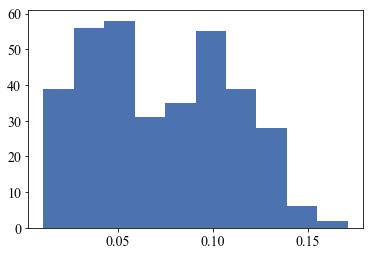

In [23]:
plt.hist([full_set[ii]['feature importance']['ks_eta'] for ii in range(len(full_set))]);

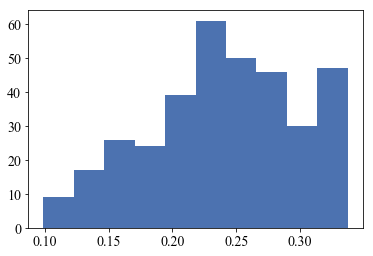

In [25]:
plt.hist([full_set[ii]['feature importance']['ks_stetson_i'] for ii in range(len(full_set))]);

In [45]:
# [f['misclassified detailed count equal bins']['EA?']
#                               for f in full_set]

In [44]:
for jj,ss in enumerate(groups):
    ii = ss[0]
    print(ii,ss)

EW ['EW']
EA/EB ['EA/EB']
RRab ['RRab']
RRc ['RRc', 'RRd']
Ell ['Ell']
CEP ['CEP', 'T2CEP']
MIRA ['MIRA', 'SRV', 'OSARG']
DSCT ['DSCT']


/data/jls/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(11.5, 17.0)

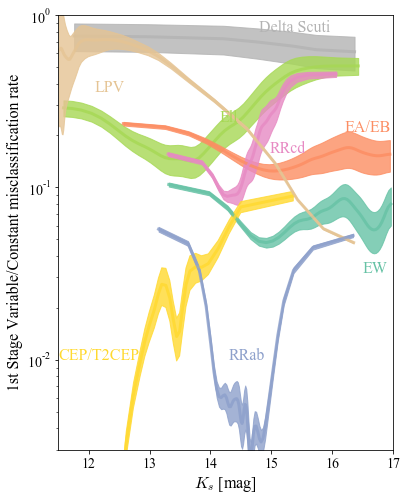

In [38]:
colors = {'CONST':'k', 'Delta Scuti':sns.color_palette()[0], 
          'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3]
         , 'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 
          'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 
          'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
lbl = {'CONST':'k', 'DSCT':'Delta Scuti', 
          'EA/EB':'EA/EB', 'EW':'EW', 'RRab':'RRab'
         , 'RRc':'RRcd', 'OSARG':sns.color_palette()[5], 
          'Ell':'Ell', 'RRd':'pink', 'CEP':'CEP/T2CEP', 
          'MIRA':'LPV', 'SRV':'red', 'T2CEP':'blue'}
zorder = {'CONST':0, 'DSCT':-4, 
          'EA/EB':0, 'EW':0, 'RRab':1
         , 'RRc':0, 'OSARG':0, 
          'Ell':-2, 'RRd':0, 'CEP':0, 
          'MIRA':0, 'SRV':0, 'T2CEP':0}
from plotting_general import running_stat
plt.figure(figsize=[6.,8.])
scaling = lambda xx: xx #np.power((xx-11.)/(17-11.),3.)
from scipy.ndimage import gaussian_filter1d

xy = [[16.5,0.032],[16.2,0.21],[14.3,0.01],[14.98,0.16],[14.16,0.24],[11.5,0.01],[12.1,0.36],[14.8,0.8]]
for jj,ss in enumerate(groups):
    ii = ss[0]
    x = scaling(.5*(bins_class[ii][1:]+bins_class[ii][:-1]))
    y=gaussian_filter1d(np.nanmedian([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                               for f in full_set],axis=0),2.)
    z = gaussian_filter1d(np.nanmedian([f['all detailed count equal bins'][ii] for f in full_set],axis=0)[1:]/np.diff(x), 2.)
    z = np.concatenate([[z[0]],z])
    
    scll=0.01
    plt.plot(x, y,lw=3,
                     color=sns.color_palette('Set2')[jj],label=lbl[ii],alpha=0.8,zorder=zorder[ii]+1)
    plt.fill_between(x, y*(1-scll*z/np.nanmedian(z)*20), y*(1+scll*z/np.nanmedian(z)*20),
                     color=sns.color_palette('Set2')[jj],alpha=0.8,zorder=zorder[ii])
    
    plt.annotate(lbl[ii],xy=xy[jj],color=sns.color_palette('Set2')[jj],fontsize=16)
#     xxx = np.linspace(np.min(x),np.max(x),100)
#     yyy = np.interp(xxx, x, y)
#     zzz = np.interp(xxx, x[1:], z[1:]/np.diff(x))
# #     plt.plot(x,y,color=sns.color_palette('Set2')[jj],label=lbl[ii],lw=5)
#     points = np.array([xxx, yyy]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     lc = LineCollection(segments, linewidths=zzz/np.nanmax(zzz)*20,color=sns.color_palette('Set2')[jj],label=lbl[ii])
#     plt.gca().add_collection(lc)
    
plt.ylim(3e-3,1.)

#     plt.errorbar(.5*(b[1:]+b[:-1]),n/n2,yerr=np.sqrt((1-n/n2)*n/n2/n2),label=ss,color=colors[ss],fmt='o-')
# plt.legend(loc='lower right',handlelength=0.5,fontsize=13)
plt.semilogy()
plt.xlabel(r'$K_s$ [mag]')
# plt.xlim(16.,)
plt.ylabel(r'1st Stage Variable/Constant misclassification rate')
plt.xlim(11.5,17.)
# plt.savefig('misclass.pdf', bbox_inches='tight')

In [46]:
full_set[0]['all detailed count equal bins']['MIRA']

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 2., 0., 0., 2., 1., 3., 0.,
       2., 1., 4., 1., 2., 0., 1., 0., 2., 1., 4., 1., 1., 3., 1., 1., 1.,
       1., 0., 1., 0., 0.])

/data/jls/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/data/jls/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/data/jls/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/data/jls/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/data/jls/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Misclassification rate')

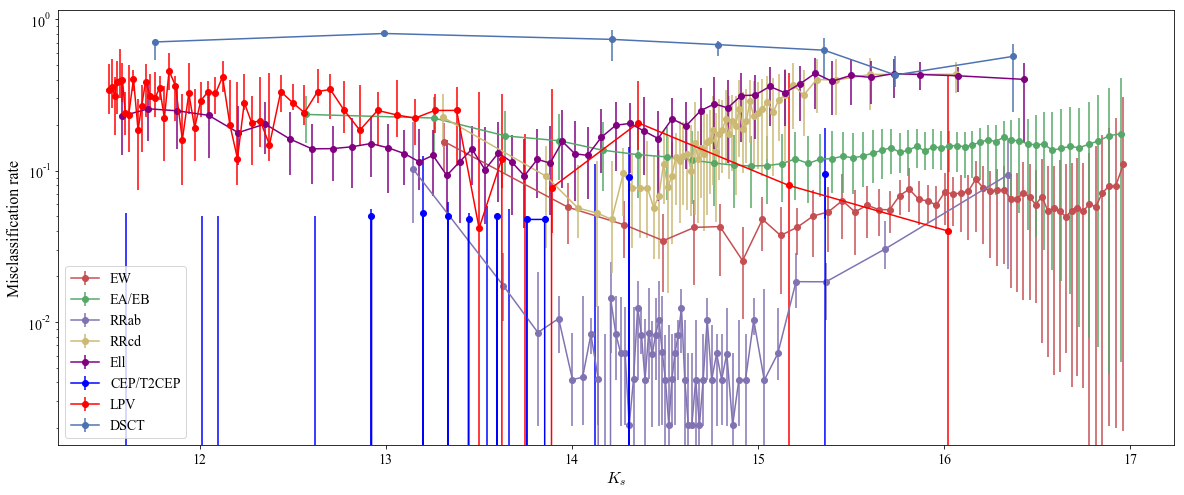

In [48]:
colors = {'CONST':'k', 'DSCT':sns.color_palette()[0], 
          'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3]
         , 'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 
          'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 
          'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
lbl = {'CONST':'k', 'DSCT':'DSCT', 
          'EA/EB':'EA/EB', 'EW':'EW', 'RRab':'RRab'
         , 'RRc':'RRcd', 'OSARG':sns.color_palette()[5], 
          'Ell':'Ell', 'RRd':'pink', 'CEP':'CEP/T2CEP', 
          'MIRA':'LPV', 'SRV':'red', 'T2CEP':'blue'}
from plotting_general import running_stat
plt.figure(figsize=[20.,8.])
scaling = lambda xx: xx #np.power((xx-11.)/(17-11.),3.)
for ss in groups:
    ii = ss[0]
    plt.errorbar(scaling(.5*(bins_class[ii][1:]+bins_class[ii][:-1])),
                 np.nanmedian([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                               for f in full_set],axis=0),
                 yerr=[
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                          for f in full_set],50.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                                        for f in full_set],5.,axis=0),
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                          for f in full_set],95.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                                        for f in full_set],50.,axis=0)],
                 color=colors[ii],fmt='o-',label=lbl[ii])

#     plt.errorbar(.5*(b[1:]+b[:-1]),n/n2,yerr=np.sqrt((1-n/n2)*n/n2/n2),label=ss,color=colors[ss],fmt='o-')
plt.legend()
plt.semilogy()
plt.xlabel(r'$K_s$')
# plt.xlim(16.,)
plt.ylabel(r'Misclassification rate')

In [47]:
const_CR = pd.DataFrame.from_dict([f['classification report']['CONST'] for f in full_set]).mean()
print(const_CR)
var_CR = pd.DataFrame.from_dict([f['classification report']['VAR'] for f in full_set]).mean()
print(var_CR)

f1-score          0.819676
precision         0.774275
recall            0.877379
support      254387.512894
dtype: float64
f1-score          0.887398
precision         0.914743
recall            0.862326
support      400272.432665
dtype: float64


In [48]:
CM=np.sum([f['confusion matrix'] for f in full_set],axis=0)/np.sum([f['confusion matrix'] for f in full_set],axis=(0,1))
print(CM)

[[0.8008348  0.08683055]
 [0.1991652  0.91316945]]


In [29]:
CM=np.sum([f['confusion matrix'] for f in full_set],axis=0)/np.sum([f['confusion matrix'] for f in full_set],axis=(0,1))
print(CM)

[[0.81472083 0.07968157]
 [0.18527917 0.92031843]]


ks_eta                   0.067459
ks_kurtosis              0.011214
ks_mad                   0.049466
ks_mad_over_error        0.069727
ks_p100_p0               0.012106
ks_p100_p0_over_error    0.004774
ks_p75_p25               0.069565
ks_p75_p25_over_error    0.055152
ks_p84_p16               0.065790
ks_p84_p16_over_error    0.041880
ks_p95_p5                0.039067
ks_p95_p5_over_error     0.018501
ks_p99_p1                0.016825
ks_p99_p1_over_error     0.007148
ks_skew                  0.021116
ks_stdev                 0.044750
ks_stdev_over_error      0.014754
ks_stetson_i             0.209345
ks_stetson_j             0.175071
ks_stetson_k             0.006288
dtype: float64


Text(0.5, 0, 'Feature importance')

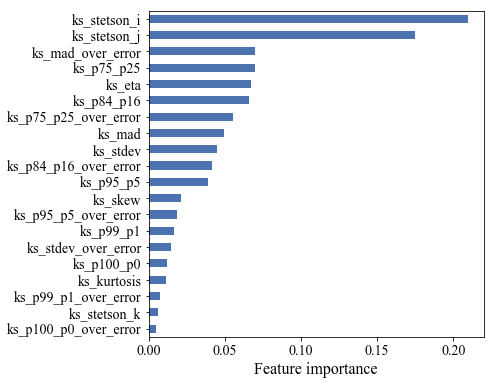

In [198]:
plt.figure(figsize=[6.,6.])
df=pd.DataFrame.from_dict([f['feature importance'] for f in full_set]).mean()
print(df)
df.nsmallest(20).plot(kind='barh')
plt.xlabel('Feature importance')

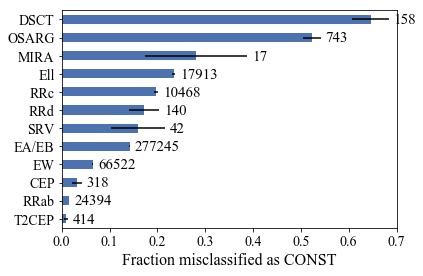

In [31]:
total_classes = pd.DataFrame.from_dict([f['total number per class'] for f in full_set])
misclassified = pd.DataFrame.from_dict([f['total per class classified as const'] for f in full_set])
rates = (misclassified/total_classes).mean().nsmallest(20)[:-1]
C=total_classes.mean().to_dict()
Xerr = [np.sqrt(R*(1-R)/C[d]) for R,d in zip(rates.values,rates.keys())]
rates.plot(kind='barh', xerr=Xerr)
plt.xlabel(r'Fraction misclassified as CONST')
plt.xlim(0.,0.7)
[plt.annotate('%i'%C[c],(d+0.01+x,i-0.25),fontsize=15) 
 for i,(d,c,x) in enumerate(zip(rates.values,rates.keys(),Xerr))];

In [12]:
tr=[1-full_set[ii]['total per class classified as const']['CONST']/full_set[ii]['total number per class']['CONST']
 for ii in range(len(full_set))]

In [13]:
tr2=[np.sum(full_set[ii]['misclassified detailed count equal bins']['CONST'][-15])/np.sum(full_set[ii]['all detailed count equal bins']['CONST'][-15])
 for ii in range(len(full_set))]

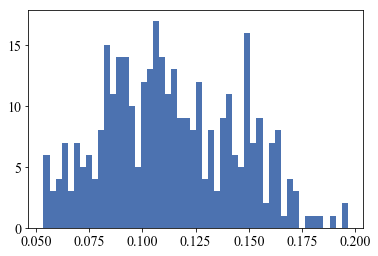

In [14]:
plt.hist(tr,bins=50);
# plt.hist(tr2,bins=50);

/data/jls/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/data/jls/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/data/jls/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/data/jls/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Misclassification rate')

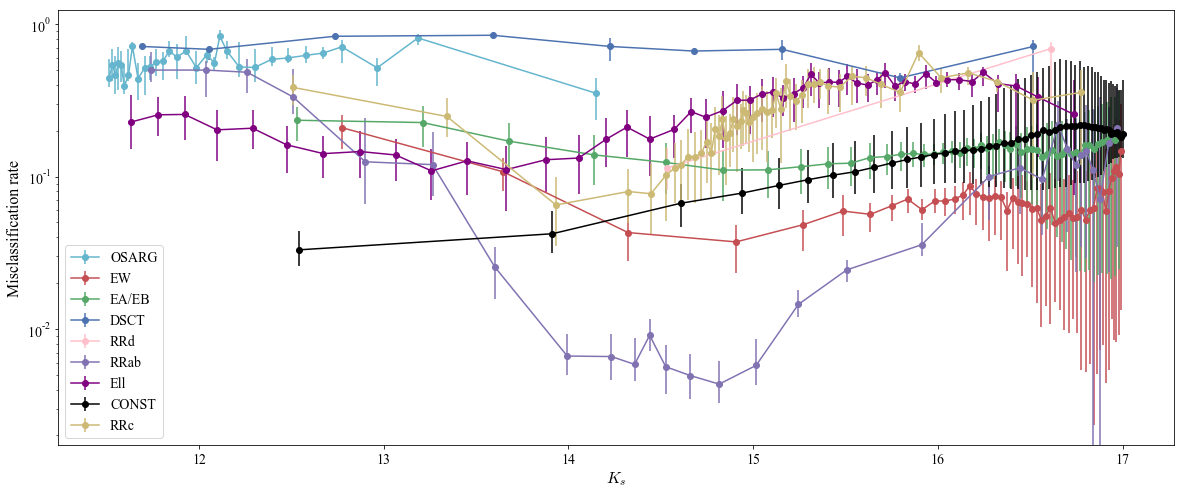

In [32]:
colors = {'CONST':'k', 'DSCT':sns.color_palette()[0], 'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3]
         , 'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
from plotting_general import running_stat
plt.figure(figsize=[20.,8.])

scaling = lambda xx: xx #np.power((xx-11.)/(17-11.),3.)
for ii in bins_class.keys():
    plt.errorbar(scaling(.5*(bins_class[ii][1:]+bins_class[ii][:-1])),
                 np.nanmedian([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],axis=0),
                 yerr=[
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],50.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],16.,axis=0),
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],84.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],50.,axis=0)],
                 color=colors[ii],fmt='o-',label=ii)

#     plt.errorbar(.5*(b[1:]+b[:-1]),n/n2,yerr=np.sqrt((1-n/n2)*n/n2/n2),label=ss,color=colors[ss],fmt='o-')
plt.legend()
plt.semilogy()
plt.xlabel(r'$K_s$')
# plt.xlim(16.,)
plt.ylabel(r'Misclassification rate')

/data/jls/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/data/jls/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


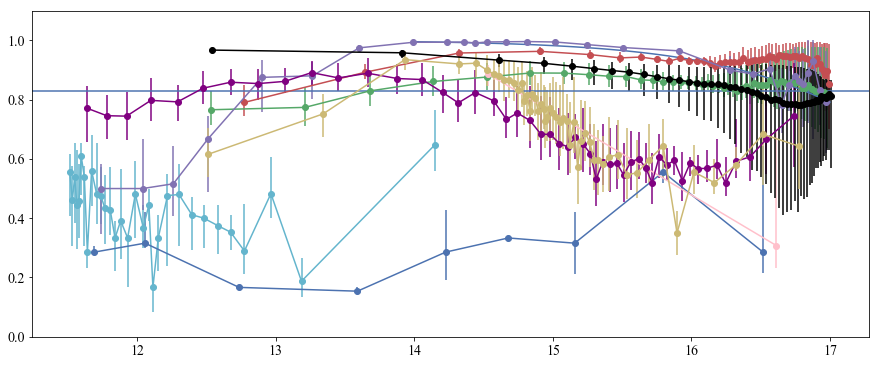

In [58]:
plt.figure(figsize=[15.,6.])
for ii in bins_class.keys():
    plt.errorbar(scaling(.5*(bins_class[ii][1:]+bins_class[ii][:-1])),
                 1-np.nanmedian([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],axis=0),
                 yerr=[
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],84.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],50.,axis=0),
        np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],50.,axis=0)
                     -np.nanpercentile([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] for f in full_set],16.,axis=0)],
                 color=colors[ii],fmt='o-',label=ii)
plt.ylim(0.,1.1)
plt.axhline(0.83)
xx = np.linspace(14.,17.)
plt.plot(xx, .5*(1-np.tanh((xx-18.)/1.5)))

In [17]:
full_set['total number per class']

CONST    404338
EA/EB    277105
EW        66352
RRab      24288
Ell       17989
RRc       10501
OSARG       753
T2CEP       374
CEP         316
DSCT        159
RRd         141
SRV          40
MIRA         18
Name: detailed_var_class, dtype: int64

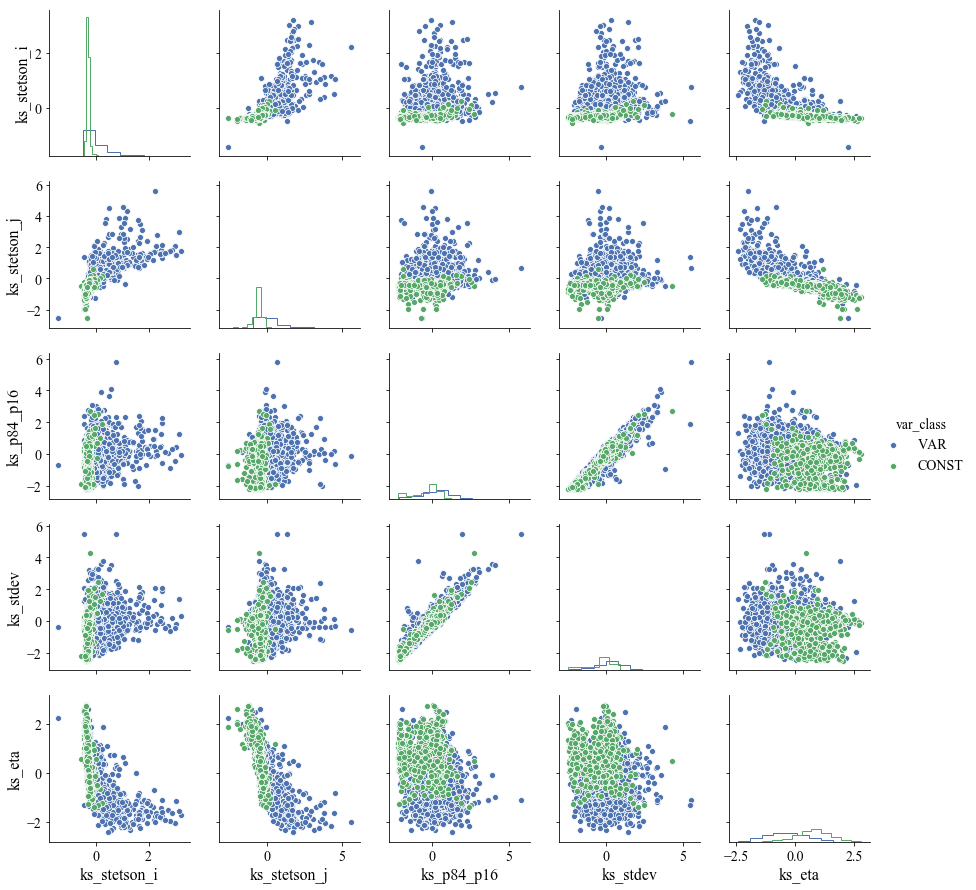

In [146]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/edr3/binary_training_set_24.pkl', 'rb') as f:
    binary = pickle.load(f)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_stdev','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

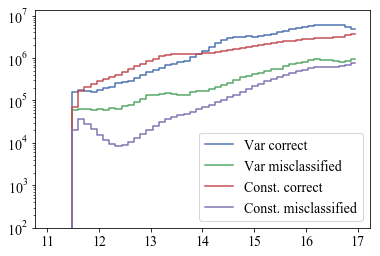

In [109]:
plt.step(full_set[0][5], np.sum([f[6] for f in full_set], axis=0), where='mid', label='Var correct')
plt.step(full_set[0][5], np.sum([f[7] for f in full_set], axis=0), where='mid', label='Var misclassified')
plt.step(full_set[0][5], np.sum([f[8] for f in full_set], axis=0), where='mid', label='Const. correct')
plt.step(full_set[0][5], np.sum([f[9] for f in full_set], axis=0), where='mid', label='Const. misclassified')

plt.semilogy()
plt.ylim(100.,)
plt.legend()

/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


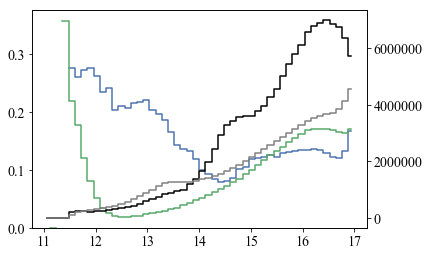

In [110]:
plt.step(full_set[0][5], np.sum([f[7] for f in full_set], axis=0)/(np.sum([f[6] for f in full_set], axis=0)+np.sum([f[7] for f in full_set], axis=0)), 
         where='mid', label='Var correct')

plt.step(full_set[0][5], np.sum([f[9] for f in full_set], axis=0)/(np.sum([f[8] for f in full_set], axis=0)+np.sum([f[9] for f in full_set], axis=0)), 
         where='mid', label='Var correct')

plt.ylim(0.,)

plt.twinx()

plt.step(full_set[0][5], (np.sum([f[6] for f in full_set], axis=0)+np.sum([f[7] for f in full_set], axis=0)), 
         where='mid', label='Var correct',color='k')
plt.step(full_set[0][5], (np.sum([f[8] for f in full_set], axis=0)+np.sum([f[9] for f in full_set], axis=0)), 
         where='mid', label='Var correct',color='gray')

In [116]:
from initial_classif.trainset.variable_training_sets import load_all_variable_stars
v = load_all_variable_stars(config)

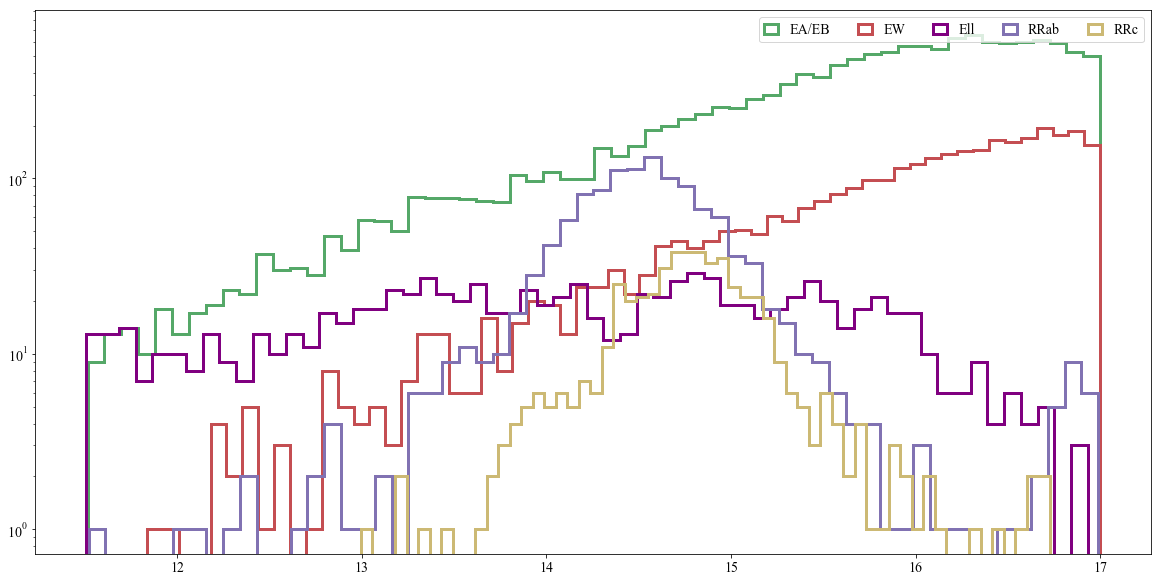

In [145]:
plt.figure(figsize=[20,10])
[plt.hist(v['ks_b_ivw_mean_mag'][v['var_class']==ss], histtype='step',bins=60,color=colors[ss],label=ss,lw=3) for ss in np.unique(v['var_class'])
        if np.count_nonzero(v['var_class']==ss)>100];
# plt.hist(v['ks_b_ivw_mean_mag'],color='k',bins=50,histtype='step',label='All',lw=3);
plt.semilogy()
plt.legend(ncol=13,handlelength=1.)

In [446]:
from initial_classif.trainset.gaia_extraction import grab_virac_gaia_region_with_stats
g = grab_virac_gaia_region_with_stats(1.,1.,2.,2.,config)

In [ ]:
f,a=plt.subplots(1,3,figsize=[15.,5.],sharey=True)
plt.sca(a[0])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[:4]];
plt.legend()
plt.semilogy()
plt.sca(a[1])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[4:8]];
plt.legend()
plt.semilogy()
plt.sca(a[2])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[8:]];
plt.legend()
plt.semilogy()
for ii in a:
    plt.sca(ii)
    plt.hist(np.log10(g['ks_p84_p16']), bins=40,histtype='step',
              range=[-2,0.5],normed=True,lw=2,label='CONST',color='k');

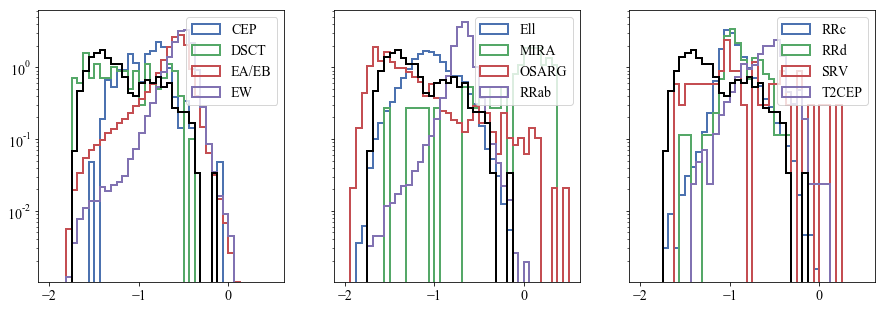

In [449]:
f,a=plt.subplots(1,3,figsize=[15.,5.],sharey=True)
plt.sca(a[0])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[:4]];
plt.legend()
plt.semilogy()
plt.sca(a[1])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[4:8]];
plt.legend()
plt.semilogy()
plt.sca(a[2])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[8:]];
plt.legend()
plt.semilogy()
for ii in a:
    plt.sca(ii)
    plt.hist(np.log10(g['ks_p84_p16']), bins=40,histtype='step',
              range=[-2,0.5],normed=True,lw=2,label='CONST',color='k');

### Test

with blah/error columns

[[15698  2237]
 [ 1927 17961]]


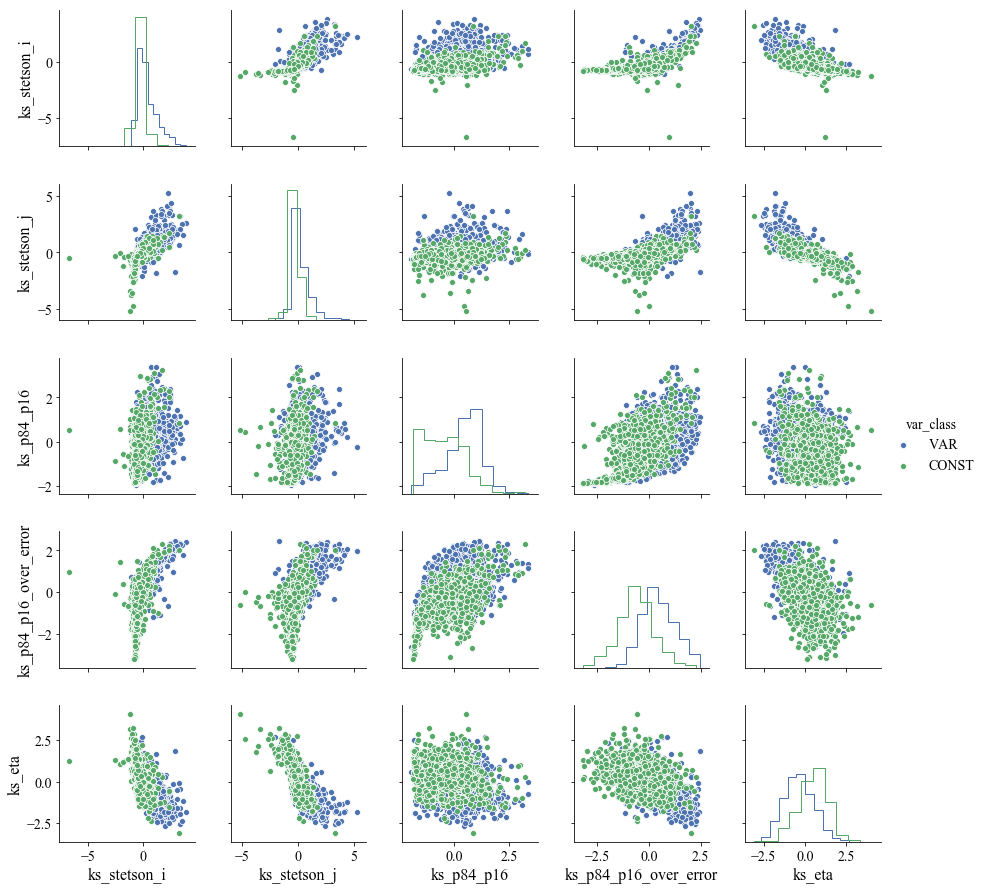

In [7]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

without blah/error columns

[[15597  2338]
 [ 2254 17634]]


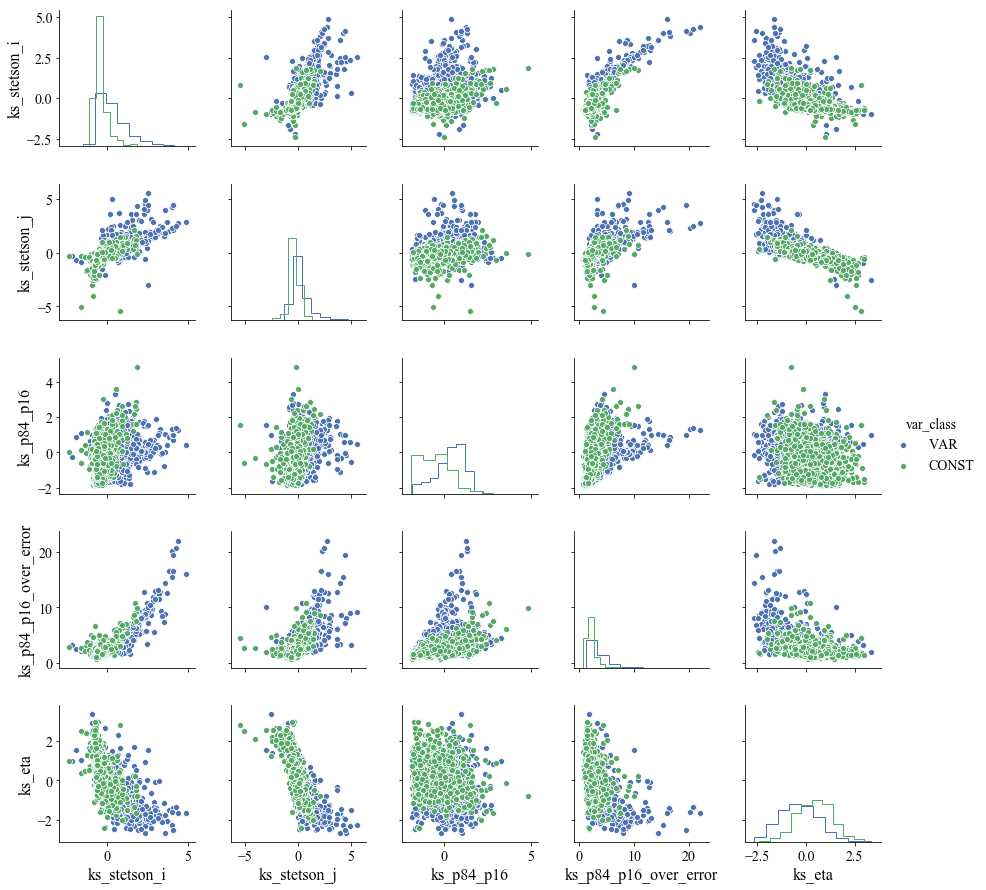

In [8]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

without OSARG/DSCT

[[15741  2194]
 [ 1929 17899]]


/data/jls/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


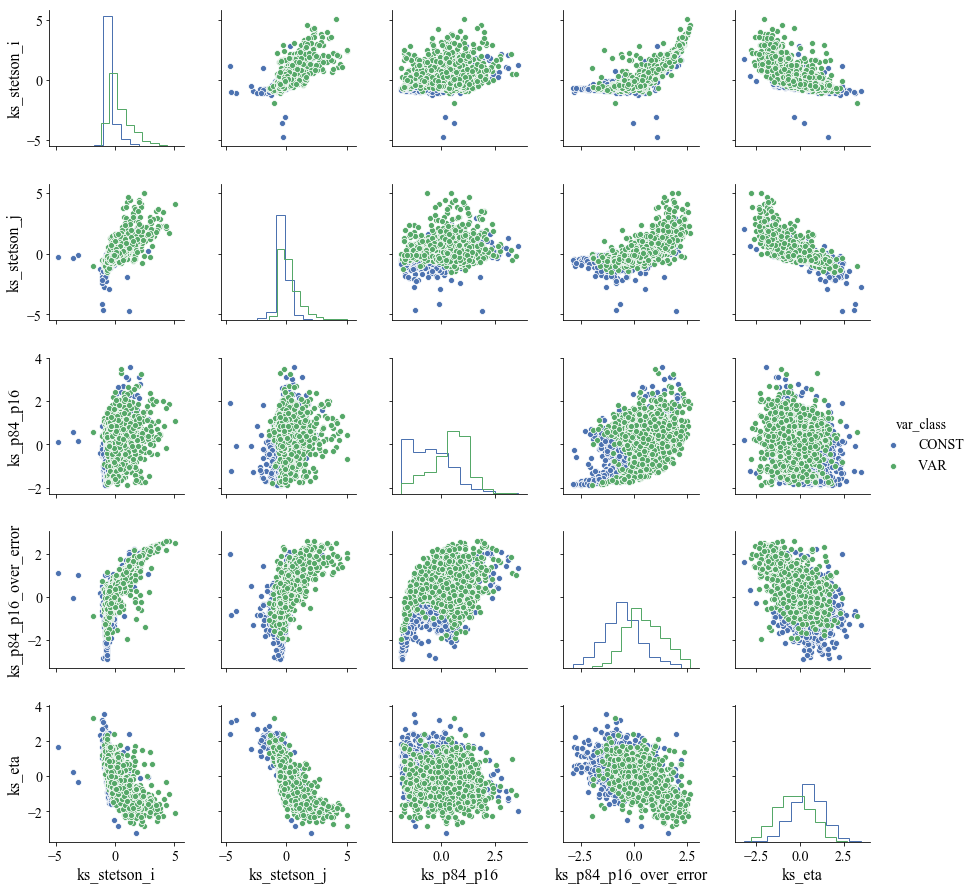

In [15]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

## Second stage training

In [33]:
from initial_classif.trainset.variable_training_sets import load_all_variable_stars
from initial_classif.trainset.gaia_extraction import generate_gaia_training_set_random
def generate_secondstage_training_for_leigh():
    config['test']='0'
    variable_stars = load_all_variable_stars(config)
    constant_data = generate_gaia_training_set_random(len(variable_stars)//10, config,
                                                      np.float64(config['gaia_percentile']),
                                                      600000)
    constant_data['var_class']='CONST'
    trainset = pd.concat([variable_stars, constant_data], axis=0, sort=False).reset_index(drop=True)
    config['test']='1'
    return trainset

In [ ]:
trainset = generate_secondstage_training_for_leigh()

In [36]:
trainset['var_class'].value_counts()

EA/EB    281477
EW        67924
CONST     37593
RRab      24837
Ell       18055
RRc       10519
OSARG       775
T2CEP       673
CEP         333
DSCT        160
RRd         141
MIRA         60
SRV          54
Name: var_class, dtype: int64

In [162]:
trainset[trainset['sourceid'].duplicated()]['g_amp']

405159   -2.220927
411903   -2.025333
419648   -1.336664
423101   -1.913778
Name: g_amp, dtype: float64

[]

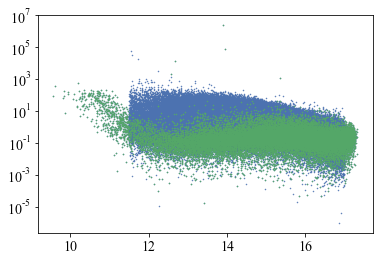

In [181]:
plt.plot(trainset['ks_b_ivw_mean_mag'],trainset['ks_stetson_i'],'.',ms=1);
plt.plot(trainset['ks_b_ivw_mean_mag'][trainset['var_class']=='CONST'],
         trainset['ks_stetson_i'][trainset['var_class']=='CONST'],'.',ms=1);

plt.semilogy()

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[]

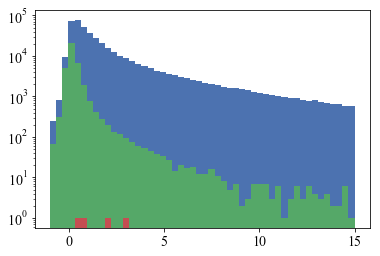

In [177]:
plt.hist(trainset['ks_stetson_i'],bins=50,range=[-1,15]);
plt.hist(trainset['ks_stetson_i'][trainset['var_class']=='CONST'],bins=50,range=[-1,15]);
plt.hist(trainset['ks_stetson_i'][trainset['sourceid'].duplicated()],bins=50,range=[-1,15]);
plt.semilogy()

In [53]:
import sqlutilpy as sqlutil
import sys
sys.path.append('../../../../')
from virac_utils import wsdb_kwargs
del wsdb_kwargs['asDict']
sqlutil.upload('jason_sanders.variable_training_set_virac2_stats_with_const_sourceid',
               (trainset['sourceid'].values, ),
               ['virac_id',], **wsdb_kwargs)

In [ ]:
cols = ['']

In [70]:
import h5py
with h5py.File("/data/jls/virac/n512_2318830.hdf5", "r") as f:
    print(f['sourceList']['h_b_ivw_mean_mag'][4])
    print(f['sourceList']['sourceid'][4])
    print(f['variabilityIndices'].keys())

17.53873
9274333000004
<KeysViewHDF5 ['ks_epoch_first', 'ks_epoch_last', 'ks_eta', 'ks_eta_e', 'ks_kurtosis', 'ks_mad', 'ks_mean', 'ks_n_epochs', 'ks_ncross_0_mad', 'ks_ncross_0_std', 'ks_ncross_10_mad', 'ks_ncross_10_std', 'ks_ncross_1_mad', 'ks_ncross_1_std', 'ks_ncross_2_mad', 'ks_ncross_2_std', 'ks_ncross_3_mad', 'ks_ncross_3_std', 'ks_ncross_5_mad', 'ks_ncross_5_std', 'ks_ncross_m10_mad', 'ks_ncross_m10_std', 'ks_ncross_m1_mad', 'ks_ncross_m1_std', 'ks_ncross_m2_mad', 'ks_ncross_m2_std', 'ks_ncross_m3_mad', 'ks_ncross_m3_std', 'ks_ncross_m5_mad', 'ks_ncross_m5_std', 'ks_p0', 'ks_p1', 'ks_p100', 'ks_p16', 'ks_p2', 'ks_p25', 'ks_p32', 'ks_p4', 'ks_p5', 'ks_p50', 'ks_p68', 'ks_p75', 'ks_p8', 'ks_p84', 'ks_p92', 'ks_p95', 'ks_p96', 'ks_p98', 'ks_p99', 'ks_pspl_count_range_0te_1te_a', 'ks_pspl_count_range_1te_0te_b', 'ks_pspl_count_range_1te_2te_a', 'ks_pspl_count_range_2te_1te_b', 'ks_pspl_count_range_2te_3te_a', 'ks_pspl_count_range_3te_2te_b', 'ks_pspl_count_range_3te_inf_a', 'ks_ps

In [80]:
from interface_utils.light_curve_loader import lightcurve_loader
l = lightcurve_loader()

In [81]:
df=l.get_data_table_per_file(2318830, 512, config)

In [133]:
grid = pd.read_pickle('/local/scratch_2/jls/virac_classifier/binary/v2/grid_test.pkl')

In [134]:
grid = pd.concat([grid, pd.DataFrame.from_dict({'index':[2],'l':[2.783411],'b':[-0.054603]})])

In [143]:
df['l'][0]=10.

In [144]:
cells = np.abs(df['l'][:,np.newaxis]-grid['l'][np.newaxis,:])<.5*np.float64(config['sizel'])
cells &= np.abs(df['b'][:,np.newaxis]-grid['b'][np.newaxis,:])<.5*np.float64(config['sizeb'])

In [148]:
np.argwhere(cells)

array([[    1,     0],
       [    2,     0],
       [    3,     0],
       ...,
       [30708,     0],
       [30709,     0],
       [30710,     0]])

In [146]:
len(np.argwhere(cells)), len(df)*2

(30710, 61422)

In [127]:
l.healpix_grid['index'][l.healpix_grid['hpx']==2318830]

5374    7380776
Name: index, dtype: int64

In [154]:
np.arange(-65.6428571434, -9.9,1.4642857143)

array([-65.64285714, -64.17857143, -62.71428571, -61.25      ,
       -59.78571429, -58.32142857, -56.85714286, -55.39285714,
       -53.92857143, -52.46428571, -51.        , -49.53571429,
       -48.07142857, -46.60714286, -45.14285714, -43.67857143,
       -42.21428571, -40.75      , -39.28571429, -37.82142857,
       -36.35714286, -34.89285714, -33.42857143, -31.96428571,
       -30.5       , -29.03571429, -27.57142857, -26.10714286,
       -24.64285714, -23.17857143, -21.71428571, -20.25      ,
       -18.78571429, -17.32142857, -15.85714286, -14.39285714,
       -12.92857143, -11.46428571, -10.        ])